<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_con_3_modelos_con_todos_los_datos_y_desde_2021_productoTOP_1_TerceraSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
from pandas import set_option, read_csv, to_datetime, merge, date_range, Series, Timedelta, DataFrame
from numpy import abs, array, mean, sqrt, where, nan, sum
from matplotlib.pyplot import plot, xlim, ylim, title, show, xlabel, ylabel, legend, figure, style, rcParams, subplots, tight_layout
from seaborn import set_palette

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,14,1,AC,SVE,VENTA COMPUTARIZADA,18110164,0,2018-11-03,POLLO SIN MENUDENCIA H-C,KG,0.0000,17.4440,209.3280,10.6800,10.6800,30.0758,FAENEADO
1,14,1,AC,SVE,VENTA COMPUTARIZADA,18110293,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,3.9160,46.9920,10.6800,10.6800,6.7515,FAENEADO
2,14,1,AC,SVE,VENTA COMPUTARIZADA,18110301,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.8654,22.4280,10.6800,10.6800,3.2227,FAENEADO
3,14,1,AC,SVE,VENTA COMPUTARIZADA,18110302,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,3.7683,45.2120,10.6800,10.6800,6.4961,FAENEADO
4,14,1,AC,SVE,VENTA COMPUTARIZADA,18110302,1,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.9251,23.1400,10.6800,10.6800,3.3250,FAENEADO


In [5]:
df['FechaMovimiento'] = to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [8]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame solo con las ventas del primer producto y un registro por día
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

# Imprimir el DataFrame df_top_1
print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'POLLO ESPECIAL', 'FILETE A GRANEL',
       'PIERNA MUSLO', 'PECHUGA', 'ALA PRIMERA', 'MUSLO', 'PIERNA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0  POLLO SIN MENUDENCIA H-C         1684
1           FILETE A GRANEL         1578
2            POLLO ESPECIAL         1552
3                    PIERNA         1504
4                     MUSLO         1397
5                   PECHUGA         1387
6              PIERNA MUSLO         1347
7                    CUELLO         1312
8               ALA PRIMERA         1253
9                    HIGADO         1188

DataFrame df_top_1:
     FechaMovimiento            NombreProducto  MontoBase
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700
2         2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140
3     

In [9]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [10]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (108283, 3)
sin noviembre  (1650, 3)
noviembre 2023  (30, 3)


### verificar las fechas faltantes y rellenarlas


In [11]:
# from sklearn.impute import KNNImputer
from copy import deepcopy

In [12]:
#df_noviembre.head()
print(df_todo_hasta_nov)
print(df_todo_hasta_nov.dtypes)

     FechaMovimiento            NombreProducto  MontoBase
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700
2         2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140
3         2018-11-06  POLLO SIN MENUDENCIA H-C   704.3460
4         2018-11-07  POLLO SIN MENUDENCIA H-C   257.6550
...              ...                       ...        ...
1645      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
1646      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
1647      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
1648      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
1649      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1650 rows x 3 columns]
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object


In [13]:
df_todas_fechas_hasta_nov = deepcopy(df_todo_hasta_nov)

# Convertir la columna 'FechaMovimiento' a tipo datetime si aún no lo está
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# Establecer 'FechaMovimiento' como el índice
df_todas_fechas_hasta_nov.set_index('FechaMovimiento', inplace=True)

# Reindexar para incluir todas las fechas desde el inicio hasta el final del rango deseado
inicio = df_todas_fechas_hasta_nov.index.min()
fin = df_todas_fechas_hasta_nov.index.max()
fechas_completas = date_range(start=inicio, end=fin)

# Contar cuántas fechas faltantes se agregaron
fechas_faltantes = fechas_completas.difference(df_todas_fechas_hasta_nov.index)
contador_fechas_faltantes = len(fechas_faltantes)

# Reindexar el DataFrame para incluir todas las fechas
df_todas_fechas_hasta_nov = df_todas_fechas_hasta_nov.reindex(fechas_completas)

# # Rellenar los valores faltantes utilizando KNNImputer
# imputer = KNNImputer(n_neighbors=5)  # Puedes ajustar el número de vecinos según tu preferencia
# df_todas_fechas_hasta_nov['MontoBase'] = imputer.fit_transform(df_todas_fechas_hasta_nov[['MontoBase']])
# Rellenar los valores faltantes utilizando el método ffill() (forward fill)
df_todas_fechas_hasta_nov['MontoBase'] = df_todas_fechas_hasta_nov['MontoBase'].ffill()
# Rellenar los valores faltantes con ceros
# df_todas_fechas_hasta_nov['MontoBase'].fillna(0, inplace=True)

# Imprimir el DataFrame resultante
print("Número de fechas faltantes agregadas:", contador_fechas_faltantes)
# print(df_todas_fechas_hasta_nov)

# Reiniciar el índice y mantener el nombre de la columna de fecha
df_todas_fechas_hasta_nov.reset_index(inplace=True, drop=False)
df_todas_fechas_hasta_nov.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

# Imprimir el DataFrame resultante
print(df_todas_fechas_hasta_nov)

Número de fechas faltantes agregadas: 174
     FechaMovimiento            NombreProducto  MontoBase
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700
2         2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140
3         2018-11-06  POLLO SIN MENUDENCIA H-C   704.3460
4         2018-11-07  POLLO SIN MENUDENCIA H-C   257.6550
...              ...                       ...        ...
1819      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
1820      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
1821      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
1822      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
1823      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1824 rows x 3 columns]


In [14]:
#df_noviembre.head()
print(df_todas_fechas_hasta_nov)
print(df_todas_fechas_hasta_nov.dtypes)

     FechaMovimiento            NombreProducto  MontoBase
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700
2         2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140
3         2018-11-06  POLLO SIN MENUDENCIA H-C   704.3460
4         2018-11-07  POLLO SIN MENUDENCIA H-C   257.6550
...              ...                       ...        ...
1819      2023-10-27  POLLO SIN MENUDENCIA H-C  5064.5984
1820      2023-10-28  POLLO SIN MENUDENCIA H-C   987.0990
1821      2023-10-29  POLLO SIN MENUDENCIA H-C  2787.4978
1822      2023-10-30  POLLO SIN MENUDENCIA H-C  1635.4907
1823      2023-10-31  POLLO SIN MENUDENCIA H-C  1943.9291

[1824 rows x 3 columns]
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object


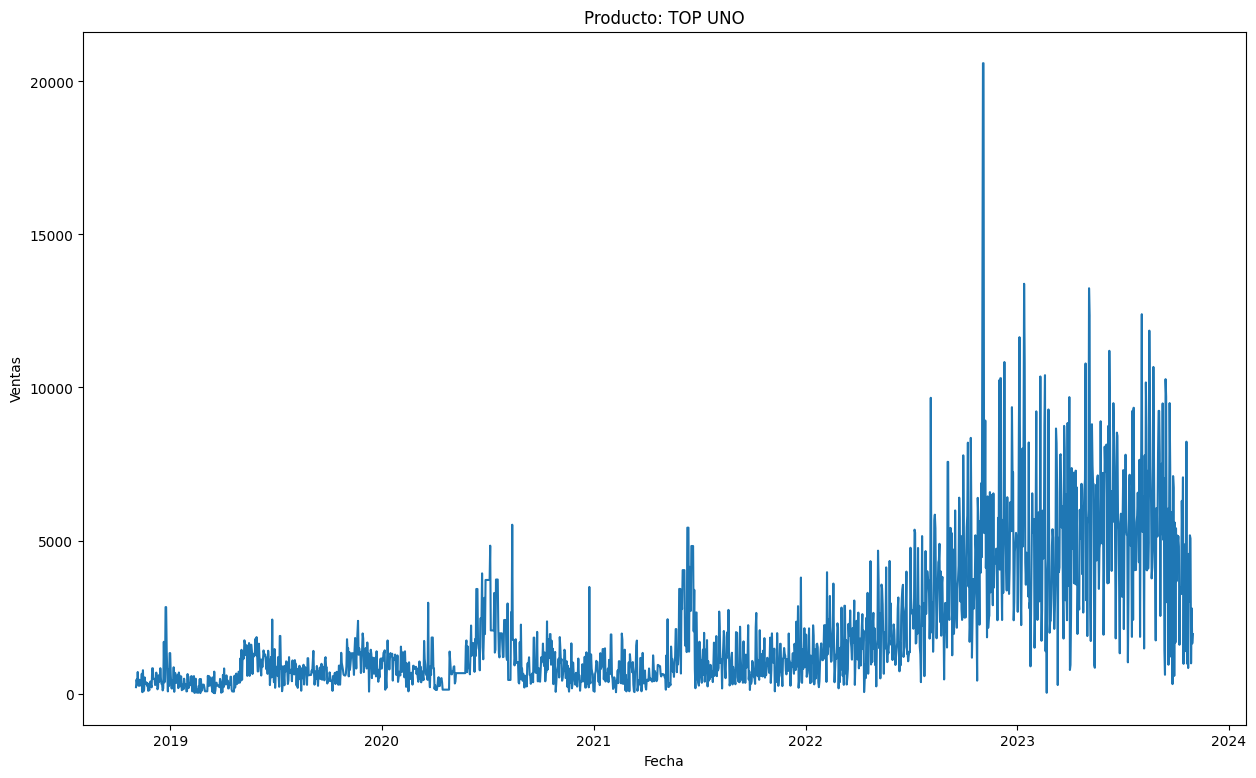

In [15]:
figure(figsize=(15, 9))
# Crear un gráfico de líneas para cada producto
plot(df_todas_fechas_hasta_nov['FechaMovimiento'], df_todas_fechas_hasta_nov['MontoBase'], label=df_todas_fechas_hasta_nov['NombreProducto'])
title(f'Producto: TOP UNO')
xlabel('Fecha')
ylabel('Ventas')
show()

In [16]:
df_noviembre.tail()

,FechaMovimiento,NombreProducto,MontoBase
1675,2023-11-26,POLLO SIN MENUDENCIA H-C,890.0623
1676,2023-11-27,POLLO SIN MENUDENCIA H-C,2294.0996
1677,2023-11-28,POLLO SIN MENUDENCIA H-C,3332.3914
1678,2023-11-29,POLLO SIN MENUDENCIA H-C,3563.8715
1679,2023-11-30,POLLO SIN MENUDENCIA H-C,4296.0834


## Evaluacion


In [17]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = where(y_true != 0)
        y_true, y_pred = array(y_true)[non_zero_indices], array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, nan)
            return nan

        # Calcular MAPE solo para los valores válidos
        return mean(abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [18]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  2476.3271
1      2023-11-02  5469.8955
2      2023-11-03  5823.3412
3      2023-11-04  5385.7282
4      2023-11-05  2729.9860
5      2023-11-06   996.0257
6      2023-11-07  1683.6664
7      2023-11-08  3041.4504
8      2023-11-09  5344.3076
9      2023-11-10  3196.6041
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(30, 2)


# PROPHET


### Preparado de los DataFrame

In [19]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todas_fechas_hasta_nov['FechaMovimiento'] = df_todas_fechas_hasta_nov['FechaMovimiento'].dt.date

# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todas_fechas_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase
1650      2023-11-01  POLLO SIN MENUDENCIA H-C  2476.3271
1651      2023-11-02  POLLO SIN MENUDENCIA H-C  5469.8955
1652      2023-11-03  POLLO SIN MENUDENCIA H-C  5823.3412
1653      2023-11-04  POLLO SIN MENUDENCIA H-C  5385.7282
1654      2023-11-05  POLLO SIN MENUDENCIA H-C  2729.9860
1655      2023-11-06  POLLO SIN MENUDENCIA H-C   996.0257
1656      2023-11-07  POLLO SIN MENUDENCIA H-C  1683.6664
1657      2023-11-08  POLLO SIN MENUDENCIA H-C  3041.4504
1658      2023-11-09  POLLO SIN MENUDENCIA H-C  5344.3076
1659      2023-11-10  POLLO SIN MENUDENCIA H-C  3196.6041
1660      2023-11-11  POLLO SIN MENUDENCIA H-C  1969.6056
1661      2023-11-12  POLLO SIN MENUDENCIA H-C  4533.3930
1662      2023-11-13  POLLO SIN MENUDENCIA H-C  3576.5896
1663      2023-11-14  POLLO SIN MENUDENCIA H-C   605.9921
1664      2023-11-15  POLLO SIN MENUDENCIA H-C  5202.4149
1665      2023-11-16  POLLO SIN MENUDENCIA

In [20]:
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]
df_todo_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
    FechaMovimiento            NombreProducto  MontoBase
790      2021-01-01                       NaN    86.5970
791      2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740
792      2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020
793      2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040
794      2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
(1650, 3)
    FechaMovimiento            NombreProducto  MontoBase
790      2021-01-01                       N

<ipython-input-20-27d94f352119>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [21]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of               ds         y
0     2021-01-01   86.5970
1     2021-01-02   59.2740
2     2021-01-03  642.4020
3     2021-01-04  724.1040
4     2021-01-05 1069.3350
...          ...       ...
1029  2023-10-27 5064.5984
1030  2023-10-28  987.0990
1031  2023-10-29 2787.4978
1032  2023-10-30 1635.4907
1033  2023-10-31 1943.9291

[1034 rows x 2 columns]>
(1034, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0awq_o1h/3qnb9lpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0awq_o1h/sujbzzqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54168', 'data', 'file=/tmp/tmp0awq_o1h/3qnb9lpe.json', 'init=/tmp/tmp0awq_o1h/sujbzzqt.json', 'output', 'file=/tmp/tmp0awq_o1h/prophet_modelqzb0y_8w/prophet_model-20240320202610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0a

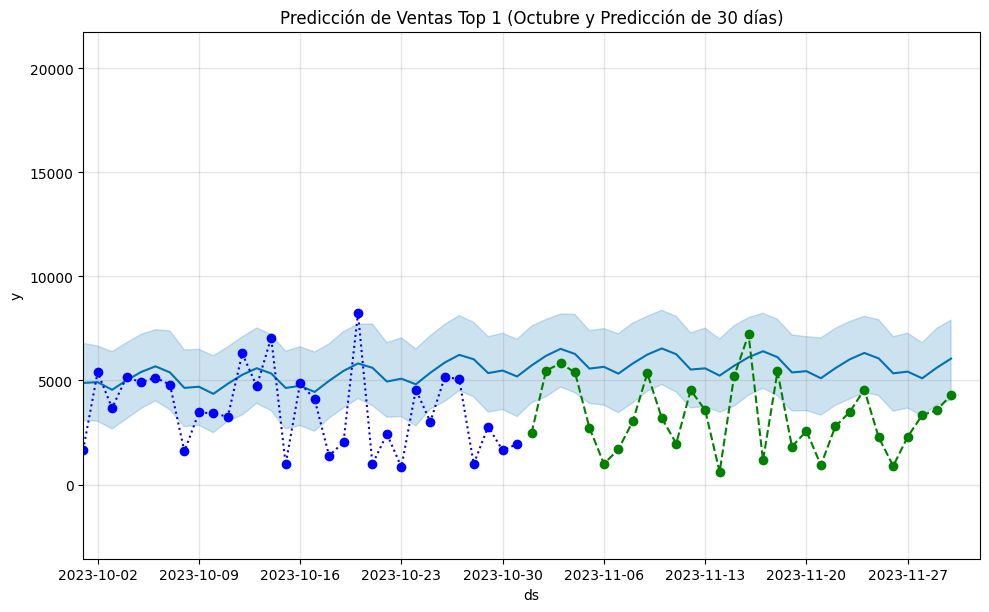

<Figure size 1600x1000 with 0 Axes>

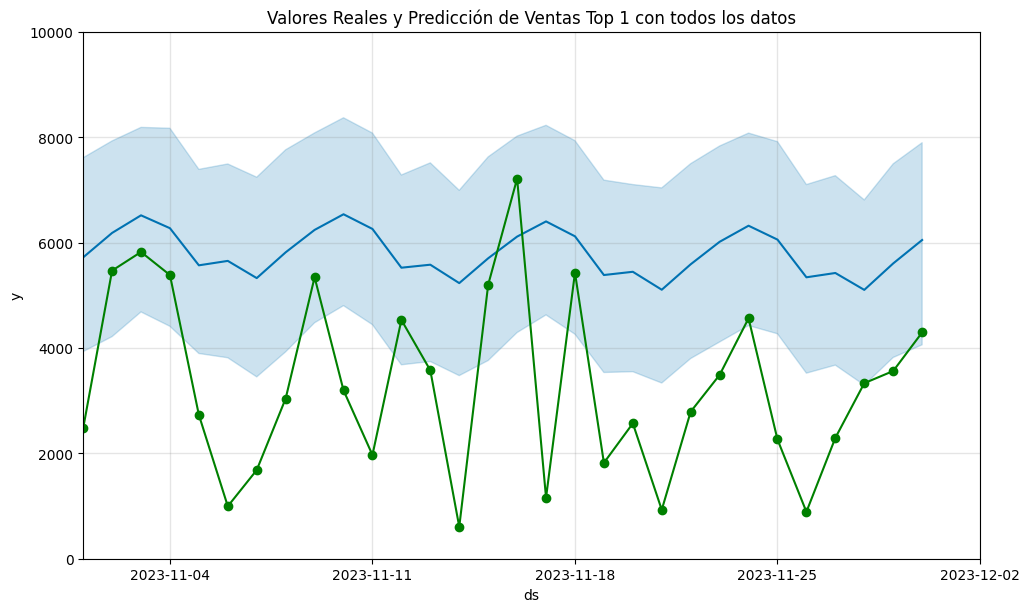

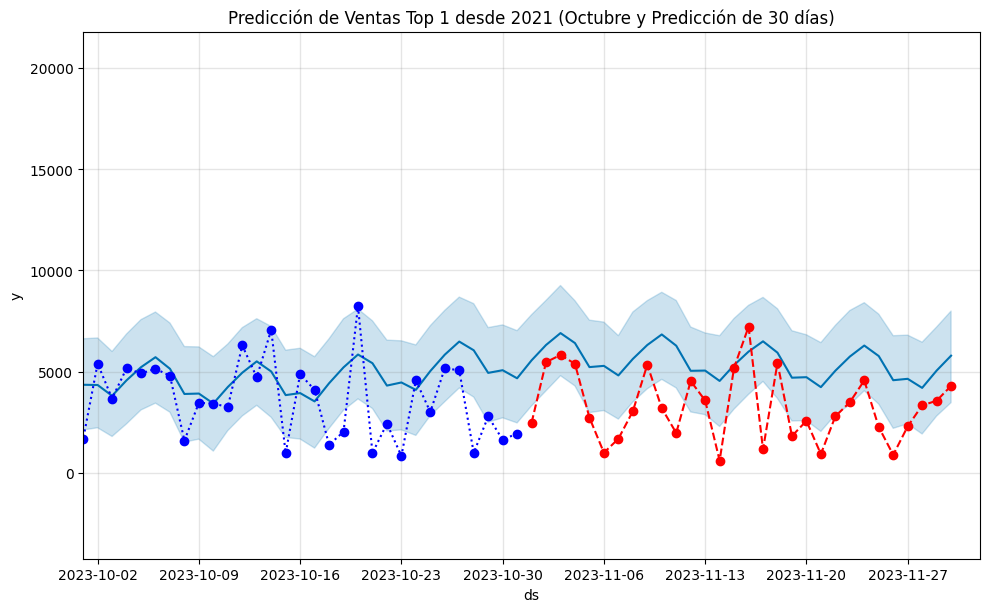

<Figure size 1600x1000 with 0 Axes>

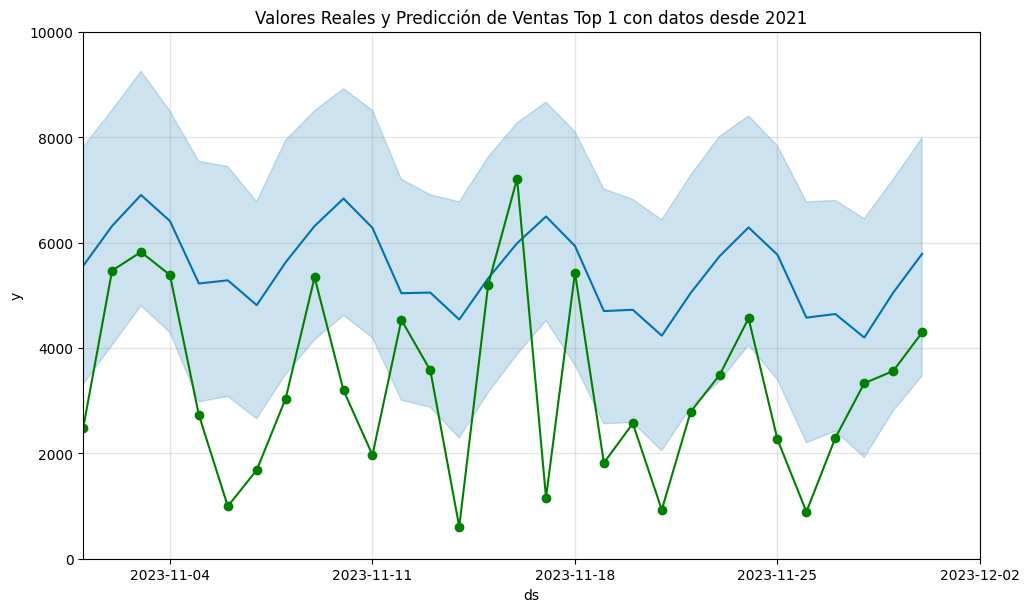

prediccion con todos los valores               ds      yhat
1824 2023-11-01 5720.9610
1825 2023-11-02 6185.2534
1826 2023-11-03 6519.3386
1827 2023-11-04 6275.0371
1828 2023-11-05 5570.2693
1829 2023-11-06 5654.3601
1830 2023-11-07 5327.7839
1831 2023-11-08 5817.2523
1832 2023-11-09 6242.5506
1833 2023-11-10 6539.5852
1834 2023-11-11 6260.9132
1835 2023-11-12 5525.1003
1836 2023-11-13 5582.0120
1837 2023-11-14 5232.5478
1838 2023-11-15 5703.7216
1839 2023-11-16 6115.4938
1840 2023-11-17 6403.8191
1841 2023-11-18 6121.1788
1842 2023-11-19 5385.9456
1843 2023-11-20 5447.6842
1844 2023-11-21 5106.8977
1845 2023-11-22 5590.1230
1846 2023-11-23 6016.7789
1847 2023-11-24 6322.2322
1848 2023-11-25 6058.3483
1849 2023-11-26 5342.8746
1850 2023-11-27 5424.7598
1851 2023-11-28 5103.9176
1852 2023-11-29 5606.3383
1853 2023-11-30 6050.9513
prediccion sin el 2020               ds      yhat
1034 2023-11-01 5559.1777
1035 2023-11-02 6317.3147
1036 2023-11-03 6905.2325
1037 2023-11-04 6411.0504
1038 2

In [22]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-10-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')
xlim([fecha_inicio, fecha_fin])
title(f'Predicción de Ventas Top 1 (Octubre y Predicción de 30 días)')
show()

figure(figsize=(16, 10))
fig = modelo1.plot(prediccion1)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con todos los datos')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,10000])
show()


fig = modelo2.plot(prediccion2)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')
xlim([fecha_inicio, fecha_fin])
title(f'Predicción de Ventas Top 1 desde 2021 (Octubre y Predicción de 30 días)')
show()

figure(figsize=(16, 10))
fig = modelo2.plot(prediccion2)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con datos desde 2021')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,10000])
show()

# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)


## EVALUACION

evaluacion con todos los datos


In [23]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)



  FechaMovimiento  MontoBase
0      2023-11-01  2476.3271
1      2023-11-02  5469.8955
2      2023-11-03  5823.3412
3      2023-11-04  5385.7282
4      2023-11-05  2729.9860
5      2023-11-06   996.0257
6      2023-11-07  1683.6664
7      2023-11-08  3041.4504
8      2023-11-09  5344.3076
9      2023-11-10  3196.6041
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


### Revisar si noviembre no tiene espacios vacios


In [24]:
if len(df_noviembre_sumaT) < 30:
    # Crear un rango de fechas de noviembre
    fechas_noviembre = date_range(start='2023-11-01', end='2023-11-30', freq='D')

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns]
    df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'])

    # Crear un DataFrame con todas las fechas de noviembre
    todas_las_fechas = DataFrame({'FechaMovimiento': fechas_noviembre})

    # Merge para obtener las fechas faltantes
    df_noviembre_sumaT = todas_las_fechas.merge(df_noviembre_sumaT, on='FechaMovimiento', how='left')

    # Llenar los valores faltantes con 0
    df_noviembre_sumaT['MontoBase'].fillna(0, inplace=True)

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns] sin tiempo
    df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'].dt.date)

    # Ordenar el DataFrame por fecha
    df_noviembre_sumaT.sort_values(by='FechaMovimiento', inplace=True)

# Asegurarse de que la longitud sea exactamente 30
assert len(df_noviembre_sumaT) == 30, "¡Error! El DataFrame no tiene 30 días."

# Imprimir el DataFrame resultante
print(df_noviembre_sumaT)

   FechaMovimiento  MontoBase
0       2023-11-01  2476.3271
1       2023-11-02  5469.8955
2       2023-11-03  5823.3412
3       2023-11-04  5385.7282
4       2023-11-05  2729.9860
5       2023-11-06   996.0257
6       2023-11-07  1683.6664
7       2023-11-08  3041.4504
8       2023-11-09  5344.3076
9       2023-11-10  3196.6041
10      2023-11-11  1969.6056
11      2023-11-12  4533.3930
12      2023-11-13  3576.5896
13      2023-11-14   605.9921
14      2023-11-15  5202.4149
15      2023-11-16  7216.1556
16      2023-11-17  1158.8779
17      2023-11-18  5431.1716
18      2023-11-19  1820.4060
19      2023-11-20  2569.6881
20      2023-11-21   928.5014
21      2023-11-22  2791.7253
22      2023-11-23  3489.6188
23      2023-11-24  4564.1603
24      2023-11-25  2263.6438
25      2023-11-26   890.0623
26      2023-11-27  2294.0996
27      2023-11-28  3332.3914
28      2023-11-29  3563.8715
29      2023-11-30  4296.0834


In [25]:
# print(df_noviembre_sumaT.dtypes)

copiar el dataframe de noviembre

In [26]:
df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

In [27]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  2476.3271       5720.9610
1       2023-11-02  5469.8955       6185.2534
2       2023-11-03  5823.3412       6519.3386
3       2023-11-04  5385.7282       6275.0371
4       2023-11-05  2729.9860       5570.2693
5       2023-11-06   996.0257       5654.3601
6       2023-11-07  1683.6664       5327.7839
7       2023-11-08  3041.4504       5817.2523
8       2023-11-09  5344.3076       6242.5506
9       2023-11-10  3196.6041       6539.5852
10      2023-11-11  1969.6056       6260.9132
11      2023-11-12  4533.3930       5525.1003
12      2023-11-13  3576.5896       5582.0120
13      2023-11-14   605.9921       5232.5478
14      2023-11-15  5202.4149       5703.7216
15      2023-11-16  7216.1556       6115.4938
16      2023-11-17  1158.8779       6403.8191
17      2023-11-18  5431.1716       6121.1788
18      2023-11-19  1820.4060       5385.9456
19      2023-11-20  2569.6881       5447.6842
20      2023-11-21   928.5014     

In [28]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 8650133.903489279
MAE is : 2593.652294547958
R2 is : -1.9998618117432105 %
------------------------------
MRSE is : 2941.1109981585664
MAPE is : 154.9207686055499 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion sin 2020

In [29]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  2476.3271       5559.1777
1       2023-11-02  5469.8955       6317.3147
2       2023-11-03  5823.3412       6905.2325
3       2023-11-04  5385.7282       6411.0504
4       2023-11-05  2729.9860       5225.3764
5       2023-11-06   996.0257       5285.4424
6       2023-11-07  1683.6664       4813.8974
7       2023-11-08  3041.4504       5628.4682
8       2023-11-09  5344.3076       6316.4244
9       2023-11-10  3196.6041       6837.7522
10      2023-11-11  1969.6056       6281.9465
11      2023-11-12  4533.3930       5040.8363
12      2023-11-13  3576.5896       5052.6922
13      2023-11-14   605.9921       4540.9981
14      2023-11-15  5202.4149       5324.0944
15      2023-11-16  7216.1556       5989.6332
16      2023-11-17  1158.8779       6497.7478
17      2023-11-18  5431.1716       5937.8474
18      2023-11-19  1820.4060       4701.4505
19      2023-11-20  2569.6881       4726.3073


In [30]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 6940104.283835956
MAE is : 2284.9372557472775
R2 is : -1.4068244541505726 %
------------------------------
MRSE is : 2634.4077671909404
MAPE is : 135.61680663917858 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




# LSTM


In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [32]:
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# print(df_todas_fechas_hasta_nov.shape)
# print(df_todo_hasta_nov.shape)
# print(df_todo_hasta_nov_prophet.shape)
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]
# print(df_todas_fechas_hasta_nov_desde_2021.shape)
# print(df_todo_hasta_nov_desde_2021.shape)
# print(df_todo_hasta_nov_desde_2021_prophet.shape)


## Todos los datos


In [33]:
# df_lstm = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

# df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

In [34]:
df_lstm = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021 =df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]


In [35]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase
FechaMovimiento           
2018-11-03        209.3280
2018-11-04        456.5700
2018-11-05        313.8140
2018-11-06        704.3460
2018-11-07        257.6550
...                    ...
2023-10-27       5064.5984
2023-10-28        987.0990
2023-10-29       2787.4978
2023-10-30       1635.4907
2023-10-31       1943.9291

[1824 rows x 1 columns]


In [36]:
# df_lstm.describe()
#df_lstm.head
df_lstm_desde_2021.describe()

,MontoBase
count,1034.0000
mean,2978.1397
std,2686.4952
min,24.9912
25%,934.2553
50%,2031.8255
75%,4536.2610
max,20594.8136


In [37]:
# Crear un objeto RobustScaler
scaler = RobustScaler()
df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

seq_length = 30  # esto tambien es la cantidad de predicciones que queremos
# X, y = create_sequences_1(df_lstm['MontoBase_scaler'].values, seq_length)
X, y = create_sequences_dwp(df_lstm['MontoBase_robust_scaler'].values, seq_length, 30)

dividir en entrenamiento y al final toda la prueba

In [38]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 31)
# train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [39]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [40]:
print(X_train.shape)
print(y_train.shape)

(1733, 30, 1)
(1733,)


In [41]:
# Construir el modelo LSTM
model = Sequential()

# model.add(LSTM(units = 300, return_sequences = False, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.15))

# # 2º capa LSTM y Dropout para regularización.
# model.add(LSTM(units = 100, return_sequences = True))
# model.add(Dropout(rate=0.2))

# 3º capa LSTM y Dropout para regularización.
model.add(LSTM(units = 200, return_sequences = False))
model.add(Dropout(rate=0.15))

# Capa de Salida!
model.add(Dense(units = 100, activation='relu'))
model.add(Dense(units = 1))

# Resumen del modelo!
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=90, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 502601 (1.92 MB)
Trainable params: 502601 

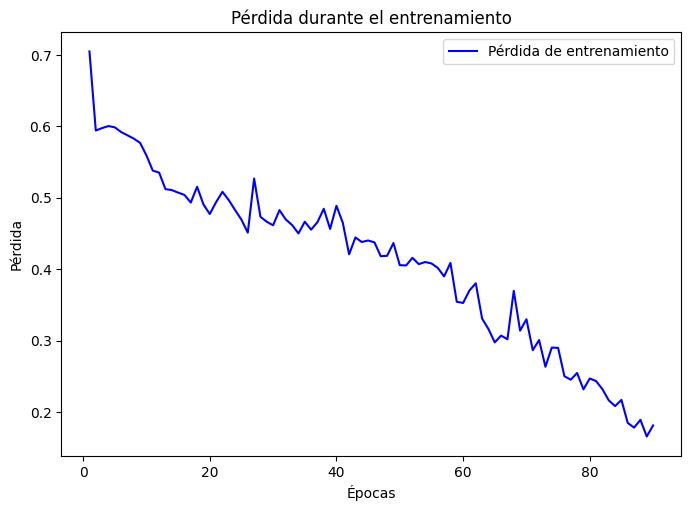

In [42]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5.5))
plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

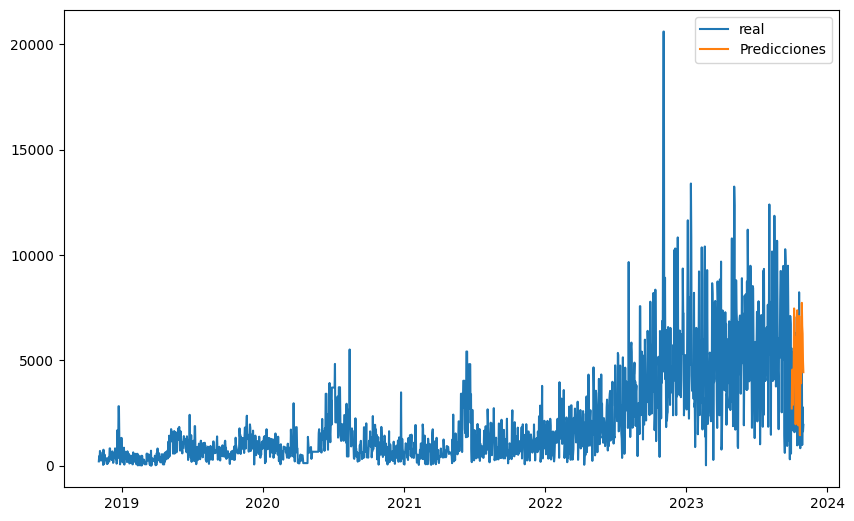

In [43]:
longitud_predicciones = len(predictions)
# Visualizar las predicciones
figure(figsize=(10, 6.2))
plot(df_lstm['MontoBase'], label='real')
plot(df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones')
legend()
show()

In [44]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1764, 30, 1)
Forma de y: (1764,)


1/1 [==============================] - 0s 89ms/step


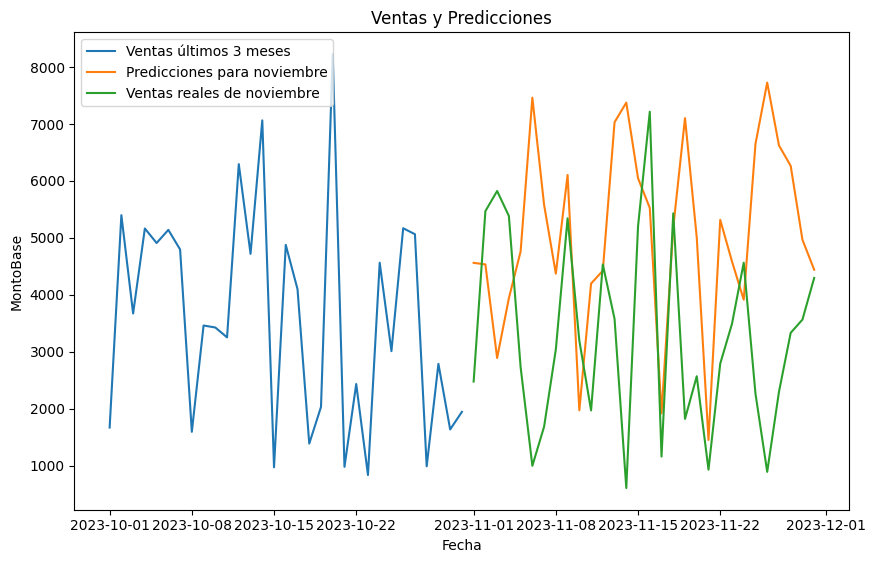

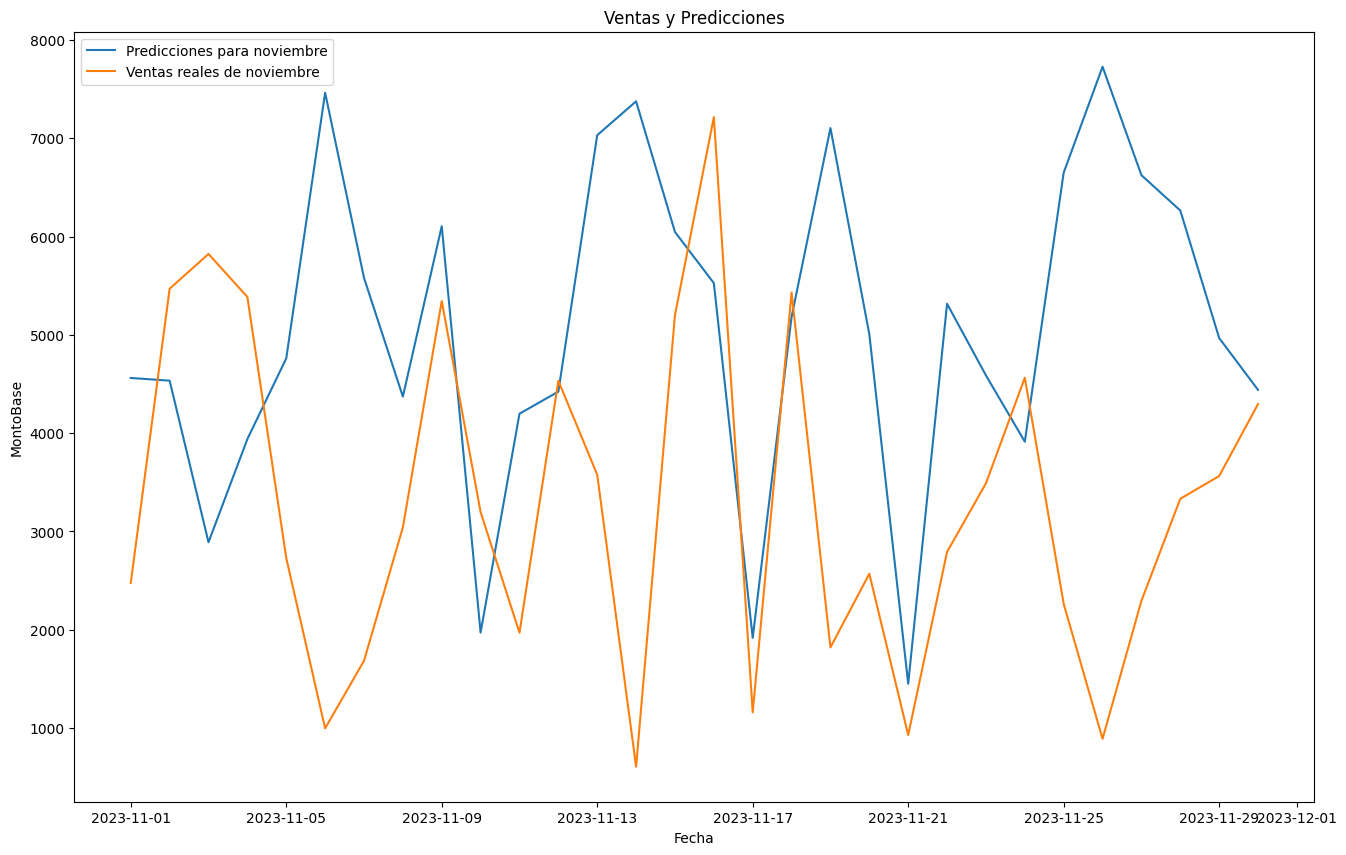

In [45]:
df_lstm.index = to_datetime(df_lstm.index)

last_3_months = df_lstm[df_lstm.index >= '2023-10-01']
last_days = df_lstm.tail(90)

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

predictions_future = model.predict(input_data)

predictions_future = scaler.inverse_transform(predictions_future)

figure(figsize=(10, 6.2))
plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(16, 10))
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

In [46]:
# last_3_months.shape
print(predictions_future.shape)

(30, 1)


### Evaluar

In [47]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  2476.3271       5720.9610    4561.5386
1       2023-11-02  5469.8955       6185.2534    4534.1958
2       2023-11-03  5823.3412       6519.3386    2890.0552
3       2023-11-04  5385.7282       6275.0371    3940.0403
4       2023-11-05  2729.9860       5570.2693    4760.8501
5       2023-11-06   996.0257       5654.3601    7463.7285
6       2023-11-07  1683.6664       5327.7839    5580.0186
7       2023-11-08  3041.4504       5817.2523    4371.9526
8       2023-11-09  5344.3076       6242.5506    6105.6792
9       2023-11-10  3196.6041       6539.5852    1971.0558
10      2023-11-11  1969.6056       6260.9132    4197.8569
11      2023-11-12  4533.3930       5525.1003    4422.7500
12      2023-11-13  3576.5896       5582.0120    7032.0459
13      2023-11-14   605.9921       5232.5478    7376.3579
14      2023-11-15  5202.4149       5703.7216    6047.1709
15      2023-11-16  7216.1556       6115.4938    5526.72

In [48]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 9511777.741189875
MAE is : 2392.352220878907
R2 is : -2.298679433861086 %
------------------------------
MRSE is : 3084.1170115917903
MAPE is : 150.9406736917653 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




## DESDE 2021

In [49]:
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = to_datetime(df_lstm_desde_2021['FechaMovimiento'])
# df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_lstm_desde_2021)

# Normalizar los datos
df_lstm_desde_2021['MontoBase_scaler'] = scaler.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences_dwp(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length, 30)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 30)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# # Construir el modelo LSTM
# model_2 = Sequential()
# model_2.add(LSTM(units=500, input_shape=(X_train.shape[1], X_train.shape[2])))

# Construir el modelo LSTM
model_2 = Sequential()
# 1º capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model_2.add(Dropout(rate=0.15))

# # 2º capa LSTM y Dropout para regularización.
# model_2.add(LSTM(units = 100, return_sequences = True))
# model_2.add(Dropout(rate=0.1))

# 3ºa capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = False))
model_2.add(Dropout(rate=0.15))

# Capa de Salida!
model_2.add(Dense(units = 100, activation='relu'))
model_2.add(Dense(units = 1))
# Resumen del modelo!
model_2.summary()
model_2.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=110, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler.inverse_transform(predictions_2)

     FechaMovimiento  MontoBase
790       2021-01-01    86.5970
791       2021-01-02    59.2740
792       2021-01-03   642.4020
793       2021-01-04   724.1040
794       2021-01-05  1069.3350
...              ...        ...
1819      2023-10-27  5064.5984
1820      2023-10-28   987.0990
1821      2023-10-29  2787.4978
1822      2023-10-30  1635.4907
1823      2023-10-31  1943.9291

[1034 rows x 2 columns]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_2 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_3 (Dropout)         (None, 200) 

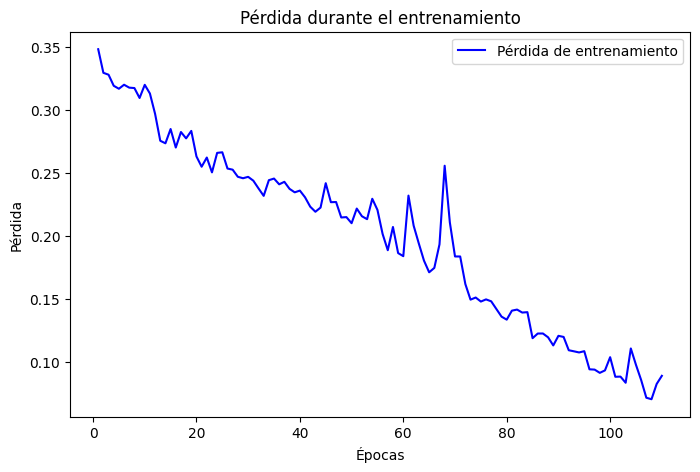

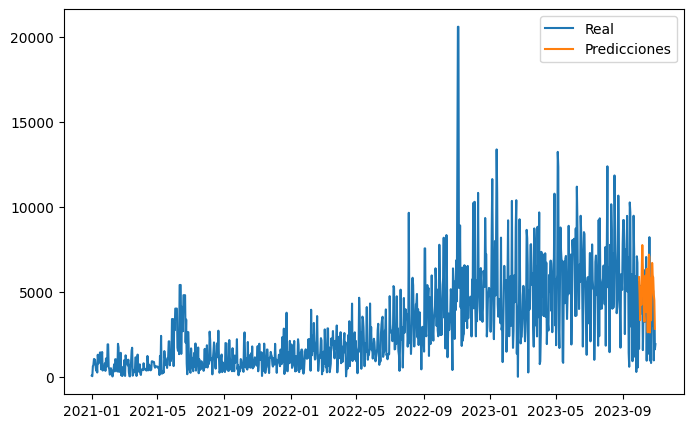

In [50]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5))
plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

# Crear un rango de fechas para las predicciones
fechas_predicciones = date_range(start='2023-10-01', periods=len(predictions_2))

# Visualizar las predicciones
figure(figsize=(8, 5))
plot(df_lstm_desde_2021['FechaMovimiento'], df_lstm_desde_2021['MontoBase'], label='Real')
plot(fechas_predicciones, predictions_2.flatten(), label='Predicciones')
legend()
show()


Forma de X: (974, 30, 1)
Forma de y: (974,)
1/1 [==============================] - 0s 58ms/step


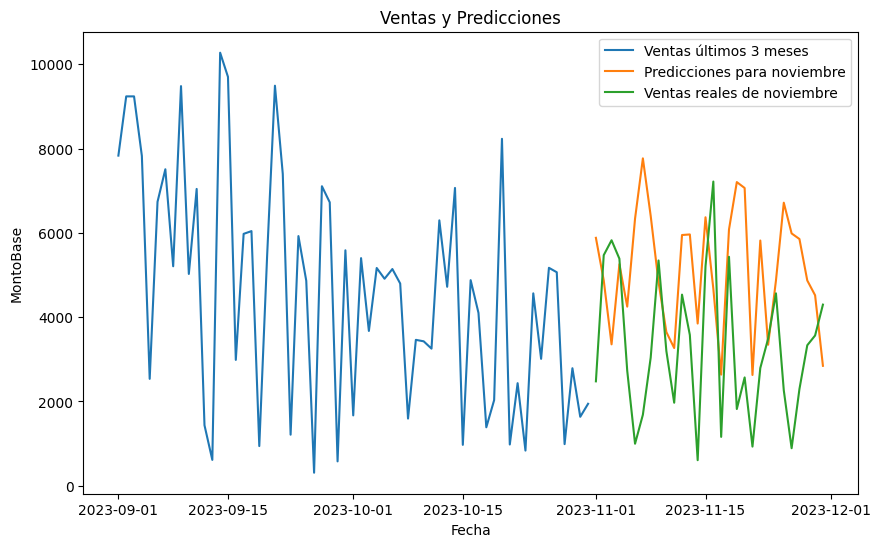

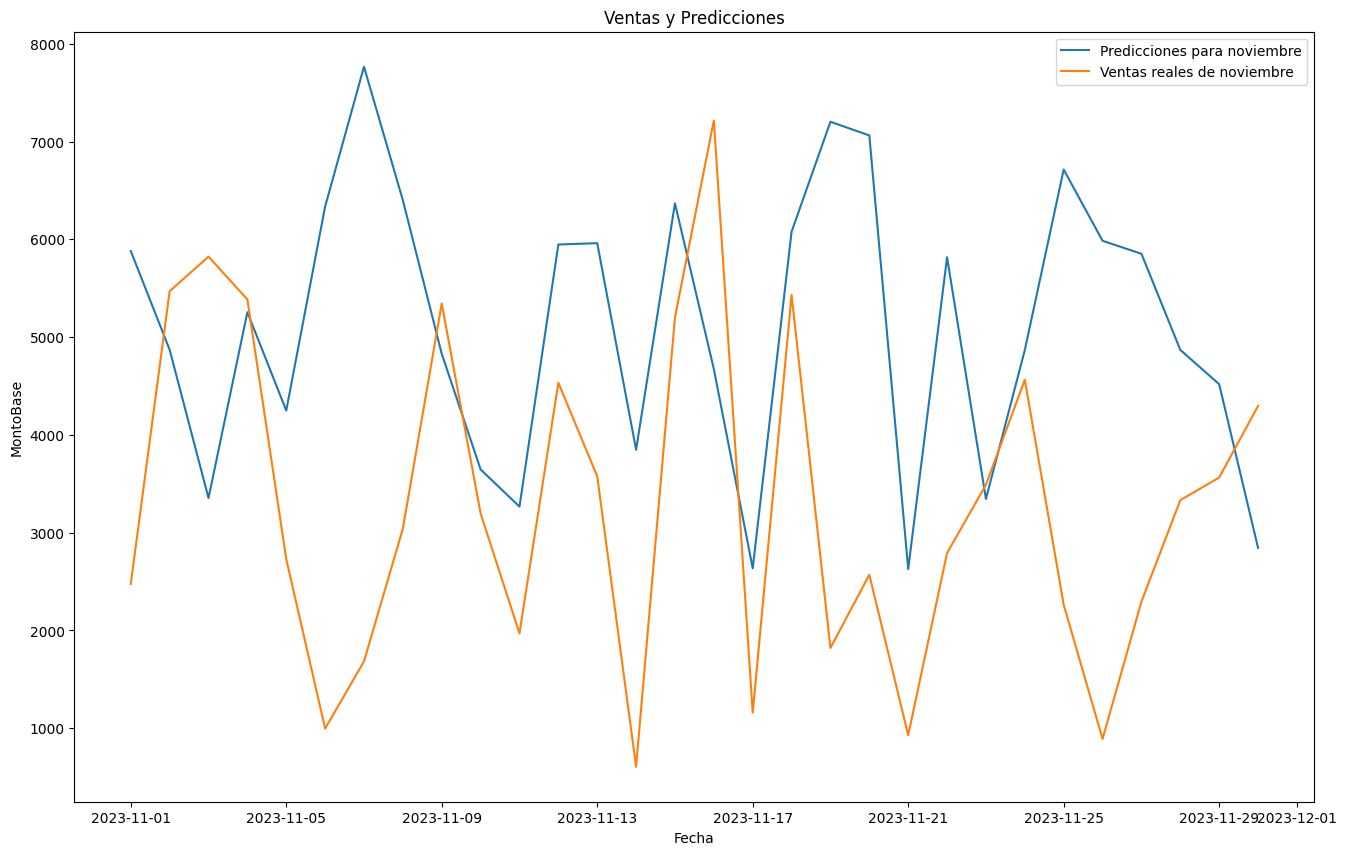

In [51]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# df_lstm_desde_2021.index = to_datetime(df_lstm_desde_2021.index)

# Preparar datos de entrada para las predicciones
last_3_months = df_lstm_desde_2021[df_lstm_desde_2021['FechaMovimiento'] >= '2023-09-01']   # Este rango de meses es para graficar pocos datos
last_days = df_lstm.tail(90)  # elegimos los ultimos valores para obtener la prediccion

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
# input_data, _ = create_sequences(input_data, seq_length)
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)


figure(figsize=(10, 6))
plot(last_3_months['FechaMovimiento'], last_3_months['MontoBase'], label='Ventas últimos 3 meses')
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(16, 10))
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

### Evaluar

In [52]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  2476.3271       5720.9610    4561.5386
1       2023-11-02  5469.8955       6185.2534    4534.1958
2       2023-11-03  5823.3412       6519.3386    2890.0552
3       2023-11-04  5385.7282       6275.0371    3940.0403
4       2023-11-05  2729.9860       5570.2693    4760.8501
5       2023-11-06   996.0257       5654.3601    7463.7285
6       2023-11-07  1683.6664       5327.7839    5580.0186
7       2023-11-08  3041.4504       5817.2523    4371.9526
8       2023-11-09  5344.3076       6242.5506    6105.6792
9       2023-11-10  3196.6041       6539.5852    1971.0558
10      2023-11-11  1969.6056       6260.9132    4197.8569
11      2023-11-12  4533.3930       5525.1003    4422.7500
12      2023-11-13  3576.5896       5582.0120    7032.0459
13      2023-11-14   605.9921       5232.5478    7376.3579
14      2023-11-15  5202.4149       5703.7216    6047.1709
15      2023-11-16  7216.1556       6115.4938    5526.72

In [53]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 8435599.476155246
MAE is : 2337.819486614584
R2 is : -1.9254613870741815 %
------------------------------
MRSE is : 2904.4103491337523
MAPE is : 132.6555800633319 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




# ARIMA

In [54]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [56]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-03,209.3280
1,2018-11-04,456.5700
2,2018-11-05,313.8140
3,2018-11-06,704.3460
4,2018-11-07,257.6550


## CON TODOS LOS AÑOS


In [57]:
# df_arima = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })
df_arima = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-03        209.3280
2018-11-04        456.5700
2018-11-05        313.8140
2018-11-06        704.3460
2018-11-07        257.6550
...                    ...
2023-10-27       5064.5984
2023-10-28        987.0990
2023-10-29       2787.4978
2023-10-30       1635.4907
2023-10-31       1943.9291

[1824 rows x 1 columns]>


In [58]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-11-03 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1824 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


### Identificar si los datos son estacionarios o no


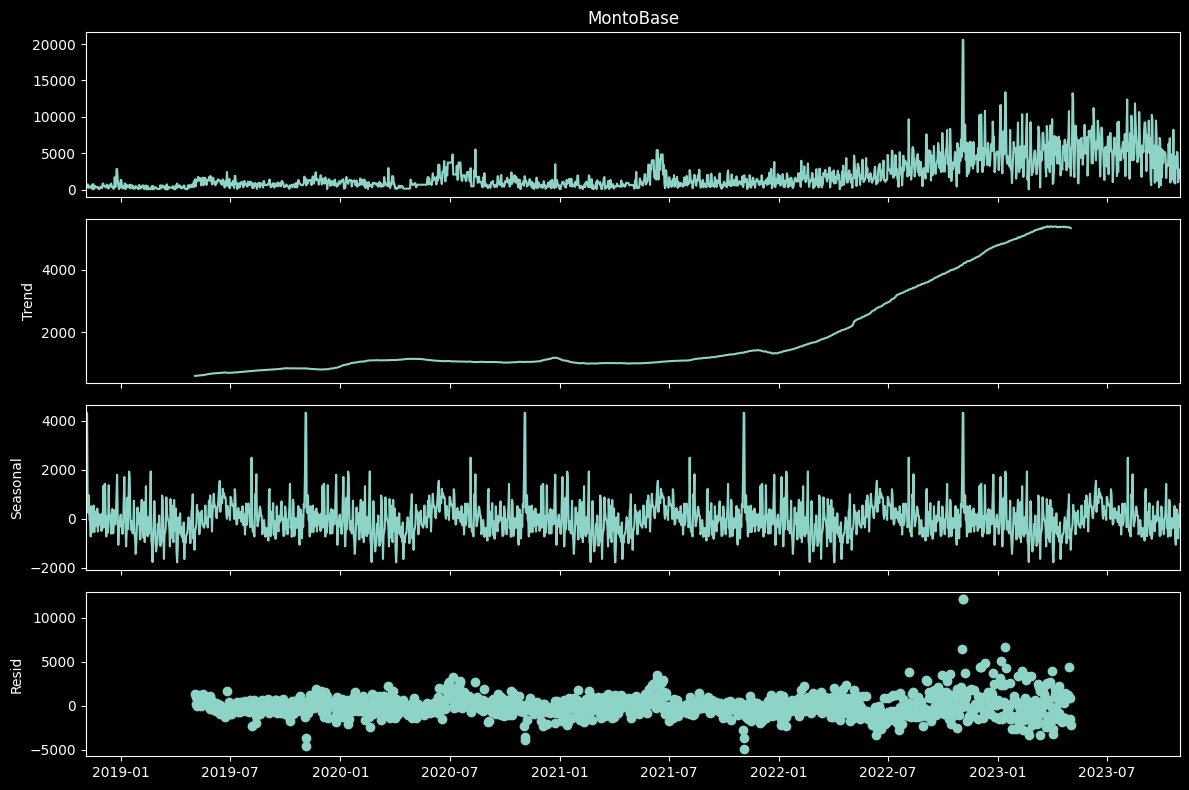

In [59]:
#style.use('seaborn')
style.use('dark_background')
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [60]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
...,...
2023-10-27,5064.5984
2023-10-28,987.0990
2023-10-29,2787.4978


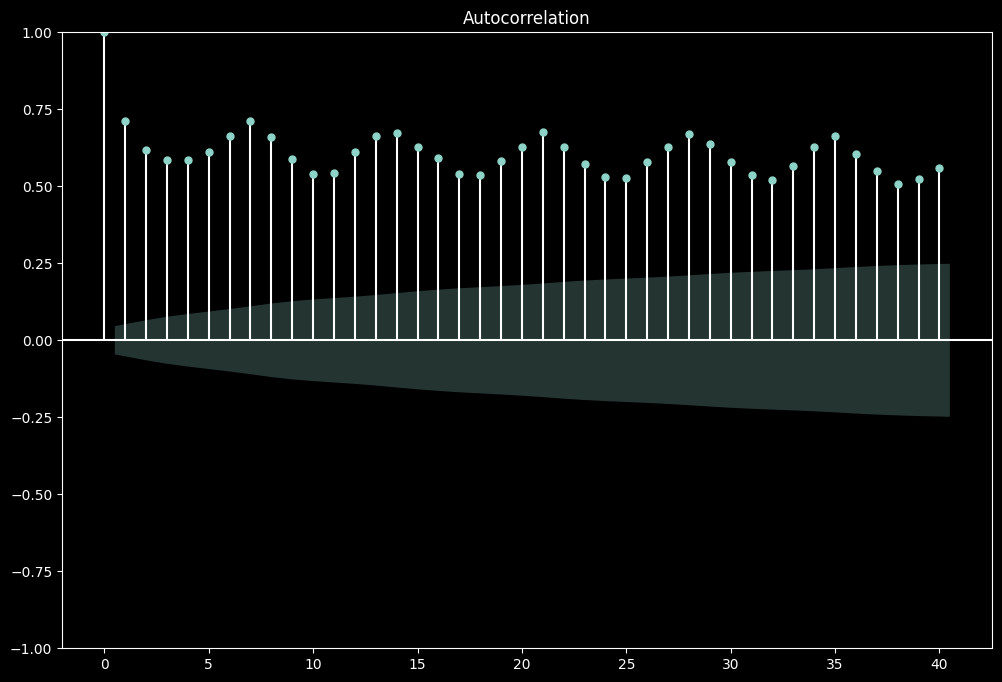

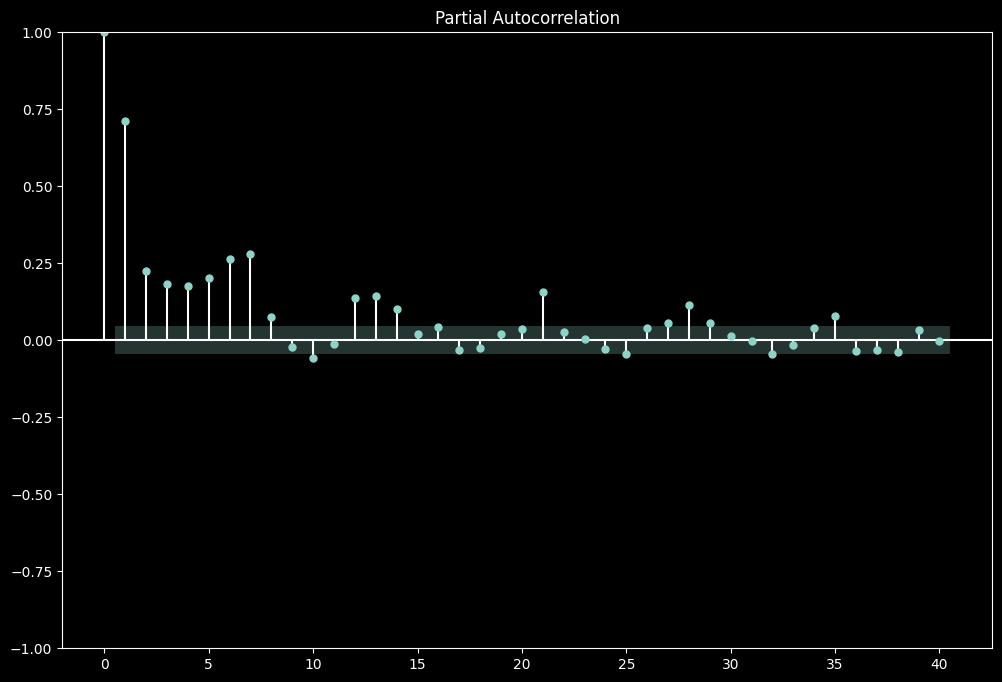

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
show()

plot_pacf(df_arima['MontoBase'], lags=40)
show()

### prueba de Dickey-Fuller

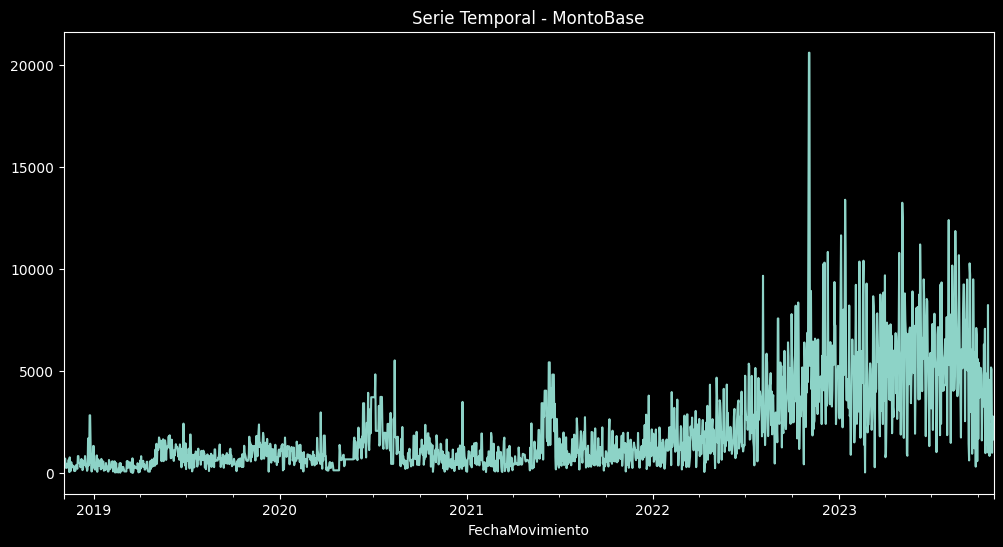

count    1824.0000
mean     2065.4303
std      2325.6523
min        10.6800
25%       579.5235
50%      1145.2965
75%      2657.8960
max     20594.8136
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -2.009017980425918
P-valor: 0.28263308115958485
Valores críticos: {'1%': -3.4339820768018106, '5%': -2.8631443597478143, '10%': -2.567624108684946}


In [62]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
title('Serie Temporal - MontoBase')
show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [63]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [64]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -2.0090
p-value                                 0.2826
No Lags Used                           20.0000
Número de observaciones utilizadas   1803.0000
Critical Value (1%)                    -3.4340
Critical Value (5%)                    -2.8631
Critical Value (10%)                   -2.5676
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


### Dividir en train y test

In [65]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 30)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [66]:
train.shape, test.shape

((1794, 1), (30, 1))

### más pruebas


In [67]:
display(df_arima.head(10))
#df_arima = df_arima.set_index('FechaMovimiento')
df_arima = df_arima.asfreq('D')
display(df_arima.head(10))
#df_arima = df_arima.asfreq(None)

,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
2018-11-08,258.9010
2018-11-09,449.4500
2018-11-10,259.7910
2018-11-11,348.9690


,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
2018-11-08,258.9010
2018-11-09,449.4500
2018-11-10,259.7910
2018-11-11,348.9690


In [68]:
print(df_arima.isnull().sum())

MontoBase    0
dtype: int64


In [69]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -2.009017980425918, p-value: 0.28263308115958485
KPSS Statistic: 4.899162814351383, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -12.5120358421099, p-value: 2.661162008553984e-23
KPSS Statistic: 0.03628106611484892, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -20.19753602795215, p-value: 0.0
KPSS Statistic: 0.030591935558943118, p-value: 0.1


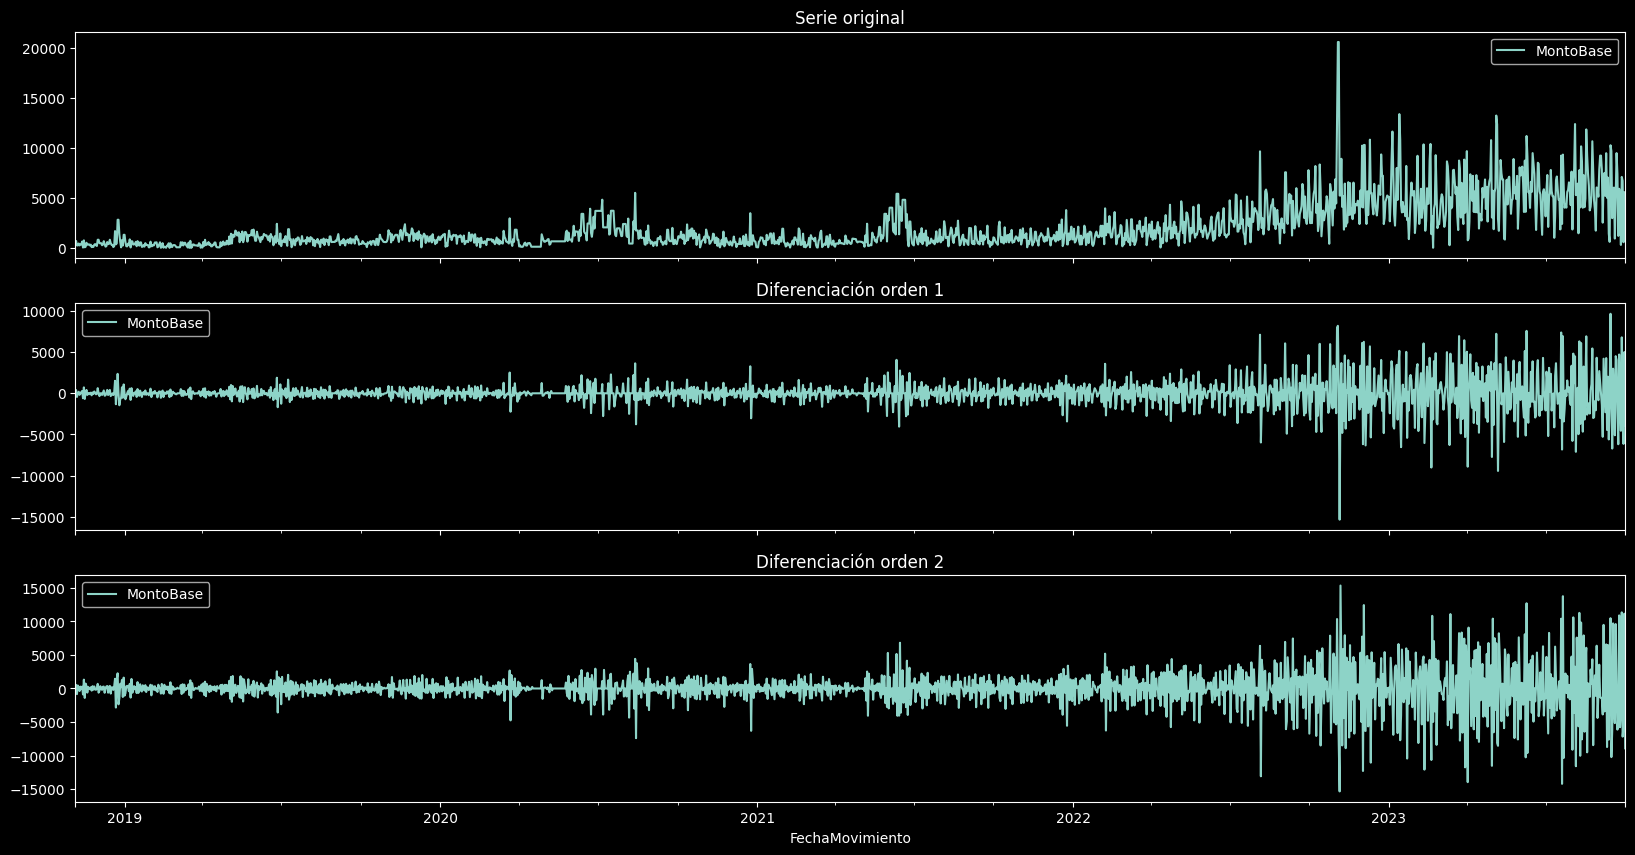

In [70]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


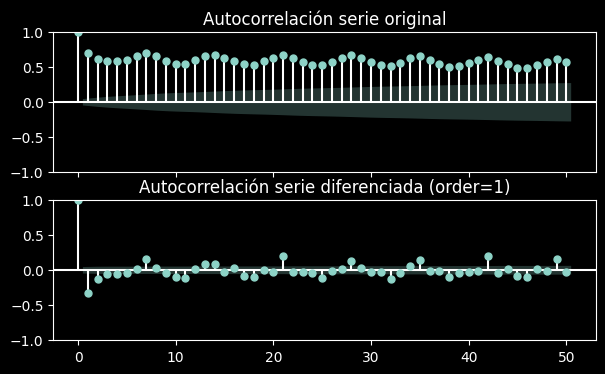

In [71]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

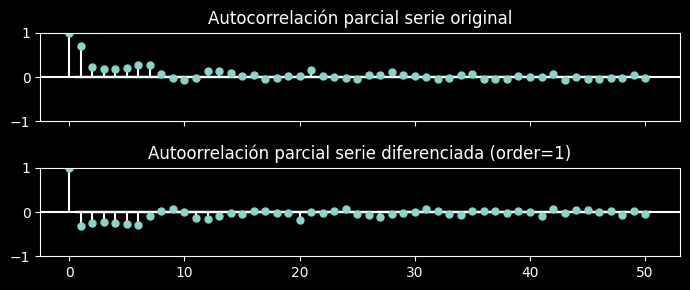

In [72]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
tight_layout();

In [73]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [75]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -15.268975223941677, p-value: 4.745945415195048e-28
KPSS Statistic: 0.016841058214720112, p-value: 0.1


### auto_arima


In [76]:
# # Modelo Auto-Arima
# from pmdarima import auto_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train,start_p=4,d=1,start_q=0,
#           max_p=8,max_d=2,max_q=1, start_P=1,
#           D=0, start_Q=1, max_P=4,max_D=1,
#           max_Q=4, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

In [78]:
# print(modelo_auto.summary())

### implementación del modelo

In [79]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-03        209.3280
2018-11-04        456.5700
2018-11-05        313.8140
2018-11-06        704.3460
2018-11-07        257.6550
...                    ...
2023-09-27       7105.2438
2023-09-28       6722.9176
2023-09-29        577.8058
2023-09-30       5585.3018
2023-10-01       1668.6165

[1794 rows x 1 columns]


In [80]:
# style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
# arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12)) # primerasucursal
# arima_model = SARIMAX(train["MontoBase"], order = (0,1,2), seasonal_order = (2,1,0,12)) # segundasucursal
# arima_model = SARIMAX(train["MontoBase"], order = (5,1,0), seasonal_order = (3,0,2,12)) # tercerasucursal
arima_model = SARIMAX(train["MontoBase"], order = (5,1,0), seasonal_order = (3,0,4,12)) # tercerasucursal
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

'''
order = (5,1,0), seasonal_order = (3,0,4,12)
    MRSE is : 1612.383675611601
    MAPE is : 71.90858726445829 %
order = (4,1,0), seasonal_order = (3,0,4,12)
    MRSE is : 1714.5352477723143
    MAPE is : 74.73503723499185 %
'''

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _Alt

'\norder = (5,1,0), seasonal_order = (3,0,4,12)\n    MRSE is : 1612.383675611601\n    MAPE is : 71.90858726445829 %\norder = (4,1,0), seasonal_order = (3,0,4,12)\n    MRSE is : 1714.5352477723143\n    MAPE is : 74.73503723499185 %\n'

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [82]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-10-02   2016.8547
2023-10-03   2077.7028
2023-10-04   3503.9970
2023-10-05   3771.9321
2023-10-06   5158.3538
2023-10-07   4586.6628
2023-10-08   2474.2826
2023-10-09   2912.8135
2023-10-10   2555.8883
2023-10-11   3087.7076
2023-10-12   3930.7588
2023-10-13   4761.2283
2023-10-14   3772.7578
2023-10-15   2819.9834
2023-10-16   2130.8430
2023-10-17   2924.7554
2023-10-18   2454.8720
2023-10-19   3750.4164
2023-10-20   5440.0481
2023-10-21   4260.7406
2023-10-22   3029.4682
2023-10-23   2128.6557
2023-10-24   2481.0736
2023-10-25   3453.5918
2023-10-26   4314.7304
2023-10-27   5485.5742
2023-10-28   4003.0073
2023-10-29   2385.1445
2023-10-30   2102.7815
2023-10-31   1966.4426
Freq: D, Name: ARIMA_Predictions, dtype: float64

In [83]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-02   2016.8547
2023-10-03   2077.7028
2023-10-04   3503.9970
2023-10-05   3771.9321
2023-10-06   5158.3538
2023-10-07   4586.6628
2023-10-08   2474.2826
2023-10-09   2912.8135
2023-10-10   2555.8883
2023-10-11   3087.7076
2023-10-12   3930.7588
2023-10-13   4761.2283
2023-10-14   3772.7578
2023-10-15   2819.9834
2023-10-16   2130.8430
2023-10-17   2924.7554
2023-10-18   2454.8720
2023-10-19   3750.4164
2023-10-20   5440.0481
2023-10-21   4260.7406
2023-10-22   3029.4682
2023-10-23   2128.6557
2023-10-24   2481.0736
2023-10-25   3453.5918
2023-10-26   4314.7304
2023-10-27   5485.5742
2023-10-28   4003.0073
2023-10-29   2385.1445
2023-10-30   2102.7815
2023-10-31   1966.4426
Name: ARIMA_Predictions, dtype: float64


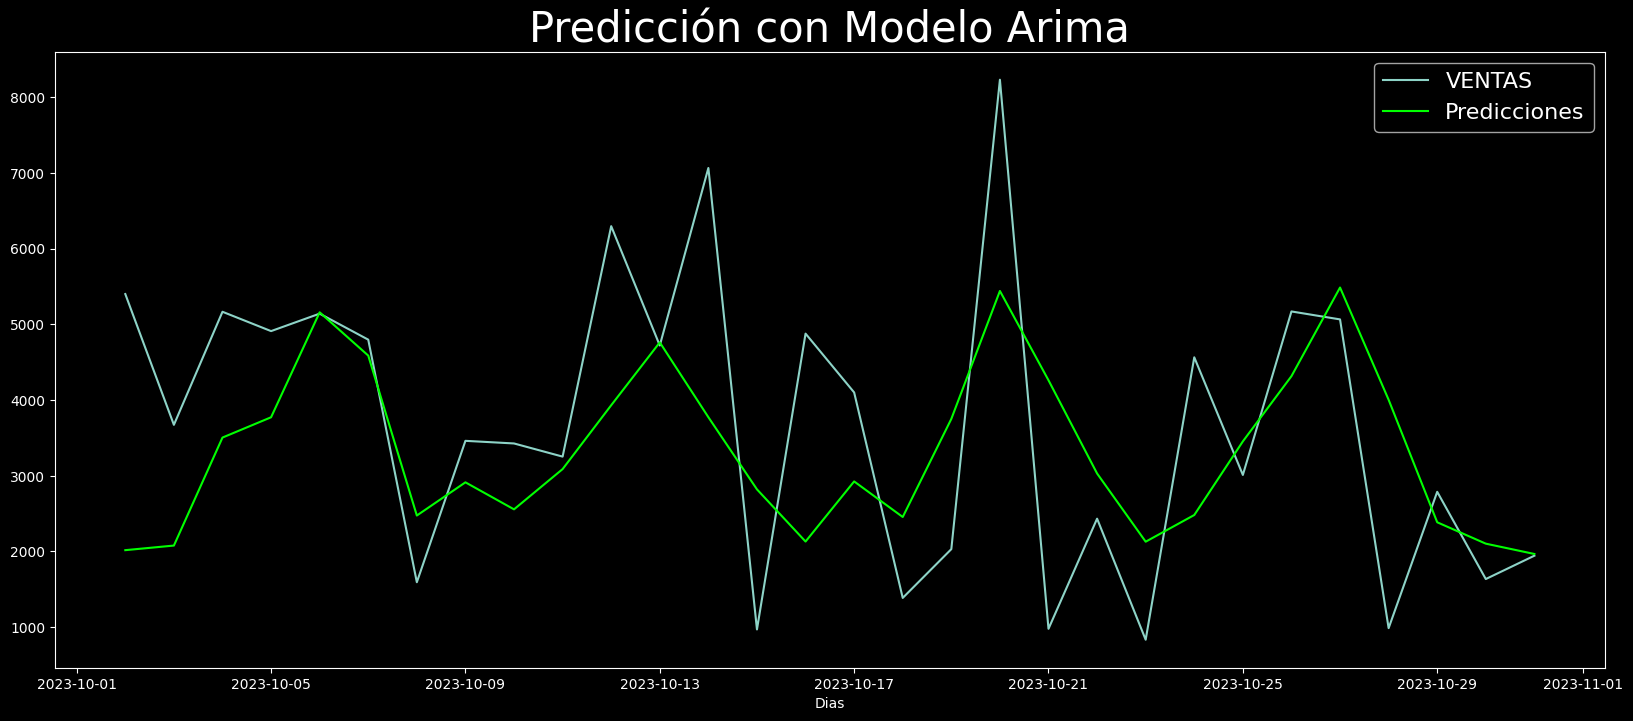

In [84]:
# style.use('dark_background')
rcParams["figure.figsize"] = (20, 8)

plot(test["MontoBase"], label="VENTAS")
plot(arima_pred, color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Dias')
ylabel('')
legend( fontsize=16);
show();

In [85]:
arima_pred2 = arima_result.predict(start = len(df_arima) ,end=len(df_arima)+29, typ="levels").rename("ARIMA Predictions")
arima_pred2
# start = 1699,end=1728 # en primera sucursal
# start = 1667,end=1697 # en segunda sucursal
# start = 1619,end=1649 # en tercera sucursal
print(f'start   = {len(df_arima)}')
print(f'end     = {len(df_arima)+30}')

start   = 1824
end     = 1854


In [86]:
# Convertir el índice de las predicciones de ARIMA a un rango de fechas
fechas_prediccion = date_range(start=df_noviembre_sumaT['FechaMovimiento'].iloc[0], periods=len(arima_pred2))

# Crear un DataFrame con las fechas y las predicciones de ARIMA
df_predicciones_arima = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred2.values})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-87-7e88e3f91a8b>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


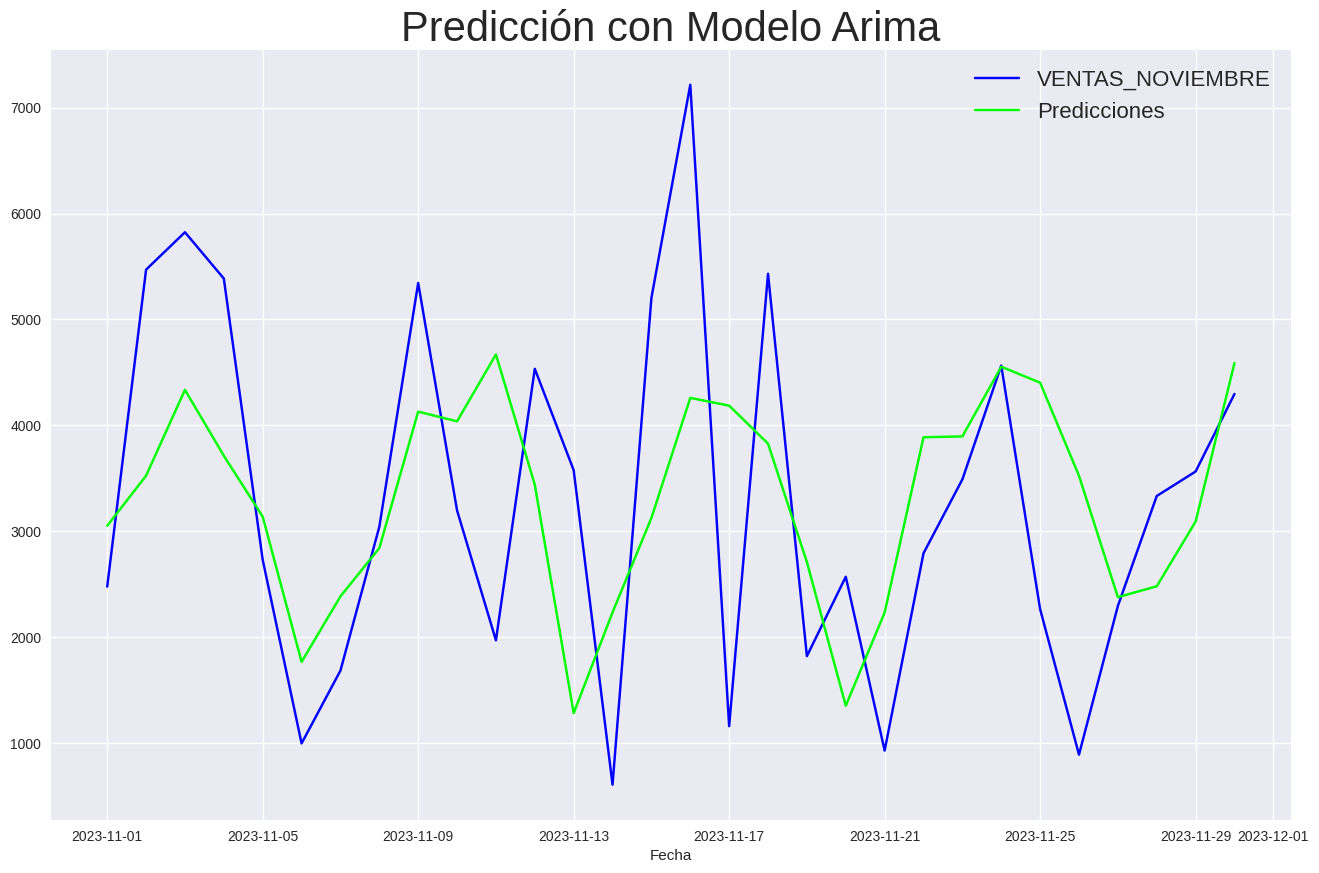

In [87]:
style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)

#plot(test["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT["MontoBase"], color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima['FechaMovimiento'],df_predicciones_arima['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30)
xlabel('Fecha')
ylabel('')
legend( fontsize=16)
show()

## Evaluar


In [88]:
df_noviembre_sumaT['Ventas_ARIMA'] = df_predicciones_arima['Ventas_ARIMA']

print(df_noviembre_sumaT.head(10))

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  2476.3271       5720.9610    4561.5386     3050.8942
1      2023-11-02  5469.8955       6185.2534    4534.1958     3524.0482
2      2023-11-03  5823.3412       6519.3386    2890.0552     4334.8802
3      2023-11-04  5385.7282       6275.0371    3940.0403     3712.8365
4      2023-11-05  2729.9860       5570.2693    4760.8501     3137.6921
5      2023-11-06   996.0257       5654.3601    7463.7285     1766.3274
6      2023-11-07  1683.6664       5327.7839    5580.0186     2384.1504
7      2023-11-08  3041.4504       5817.2523    4371.9526     2840.4245
8      2023-11-09  5344.3076       6242.5506    6105.6792     4129.0107
9      2023-11-10  3196.6041       6539.5852    1971.0558     4037.5213


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 2389483.8641911466
MAE is : 1286.4472444305222
R2 is : 0.17132827376554782 %
------------------------------
MRSE is : 1545.7955441102638
MAPE is : 63.25668284976693 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Desde el 2021

In [90]:
# df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

df_arima_desde_2021 = df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-01         86.5970
2021-01-02         59.2740
2021-01-03        642.4020
2021-01-04        724.1040
2021-01-05       1069.3350
...                    ...
2023-10-27       5064.5984
2023-10-28        987.0990
2023-10-29       2787.4978
2023-10-30       1635.4907
2023-10-31       1943.9291

[1034 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


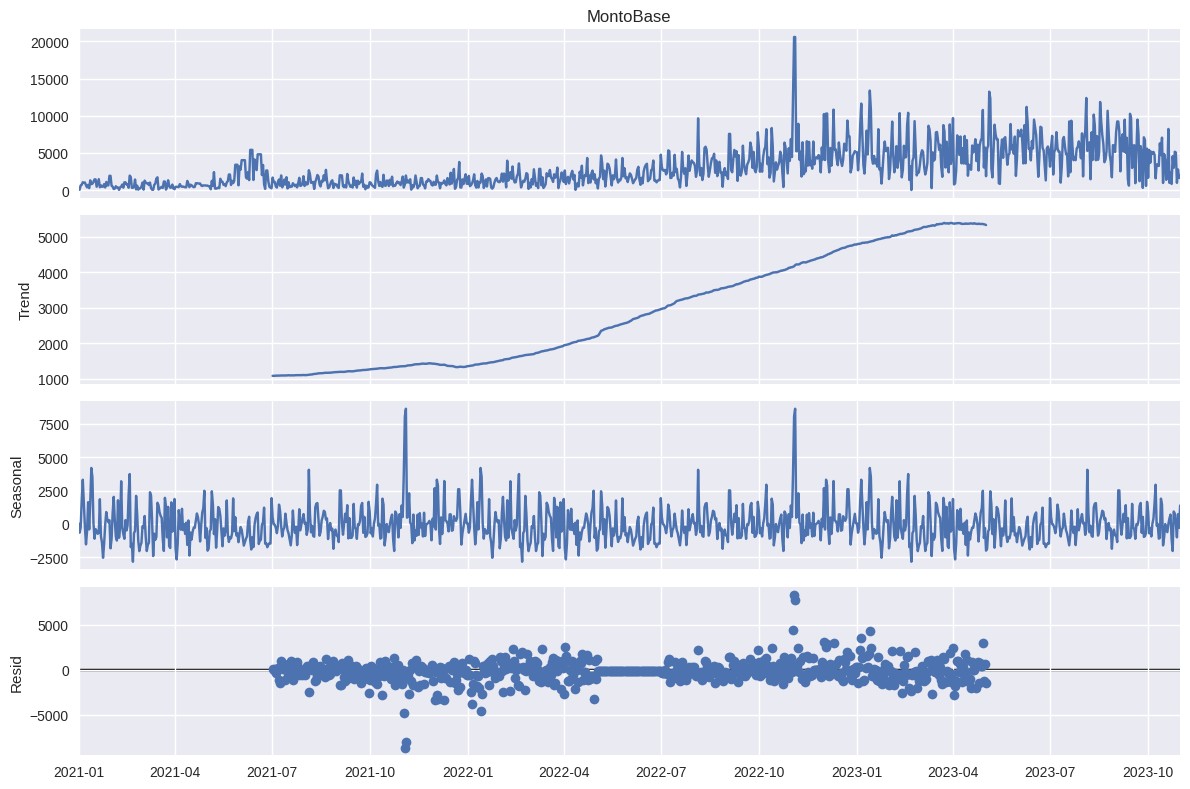

In [91]:
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [92]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 30)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
train_d21.shape, test_d21.shape

((1004, 1), (30, 1))

In [94]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-01         86.5970
2021-01-02         59.2740
2021-01-03        642.4020
2021-01-04        724.1040
2021-01-05       1069.3350
...                    ...
2023-09-27       7105.2438
2023-09-28       6722.9176
2023-09-29        577.8058
2023-09-30       5585.3018
2023-10-01       1668.6165

[1004 rows x 1 columns]


In [95]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train_d21,start_p=0,d=1,start_q=0,
#           max_p=5,max_d=2,max_q=5, start_P=0,
#           D=1, start_Q=0, max_P=3,max_D=2,
#           max_Q=3, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
# print(modelo_auto.summary())

In [97]:
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,2), seasonal_order = (2,1,0,12))
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,0), seasonal_order = (2,1,0,12))
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (5,1,0), seasonal_order = (3,1,0,12))
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,0), seasonal_order = (2,1,3,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()
'''
MAPE is : 92.21339793441139 % order = (6,1,0), seasonal_order = (3,1,4,12)
MAPE is : 96.35431413369628 % order = (6,1,0), seasonal_order = (3,0,4,12)
MAPE is : 95.4498221347714 % order = (6,1,1), seasonal_order = (3,1,4,12)
MAPE is : 96.0013095026446 % order = (7,1,0), seasonal_order = (3,1,4,12)
MAPE is : 1060.1894557022604 % order = (6,2,0), seasonal_order = (3,1,4,12)
MAPE is : 93.09434512067702 % order = (6,1,0), seasonal_order = (4,1,4,12)
MAPE is : 92.02447176674437 % order = (6,1,0), seasonal_order = (4,0,4,12)
MAPE is : 96.35431413369628 % order = (6,1,0), seasonal_order = (3,0,4,12)
MAPE is : 88.89379088975299 % order = (6,1,0), seasonal_order = (2,1,2,12)
MAPE is : 83.522194199082 % order = (5,1,0), seasonal_order = (2,1,2,12)
MAPE is : 92.31224828029461 % order = (5,1,0), seasonal_order = (3,1,2,12)
MAPE is : 72.4371523659436 % order = (5,1,0), seasonal_order = (2,1,3,12)
MAPE is : 88.8847535148525 % order = (5,1,0), seasonal_order = (2,1,4,12)
MAPE is : 84.83326548934347 % order = (5,1,0), seasonal_order = (3,1,3,12)
MAPE is : 122.80657903131807 % (5,1,1), seasonal_order = (2,1,3,12)
MAPE is : 99.49567012383288 % (6,1,0), seasonal_order = (2,1,3,12)
MAPE is : 66.43061048719491 % order = (4,1,0), seasonal_order = (2,1,3,12)
'''

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of N

'\nMAPE is : 92.21339793441139 % order = (6,1,0), seasonal_order = (3,1,4,12)\nMAPE is : 96.35431413369628 % order = (6,1,0), seasonal_order = (3,0,4,12)\nMAPE is : 95.4498221347714 % order = (6,1,1), seasonal_order = (3,1,4,12)\nMAPE is : 96.0013095026446 % order = (7,1,0), seasonal_order = (3,1,4,12)\nMAPE is : 1060.1894557022604 % order = (6,2,0), seasonal_order = (3,1,4,12)\nMAPE is : 93.09434512067702 % order = (6,1,0), seasonal_order = (4,1,4,12)\nMAPE is : 92.02447176674437 % order = (6,1,0), seasonal_order = (4,0,4,12)\nMAPE is : 96.35431413369628 % order = (6,1,0), seasonal_order = (3,0,4,12)\nMAPE is : 88.89379088975299 % order = (6,1,0), seasonal_order = (2,1,2,12)\nMAPE is : 83.522194199082 % order = (5,1,0), seasonal_order = (2,1,2,12)\nMAPE is : 92.31224828029461 % order = (5,1,0), seasonal_order = (3,1,2,12)\nMAPE is : 72.4371523659436 % order = (5,1,0), seasonal_order = (2,1,3,12)\nMAPE is : 88.8847535148525 % order = (5,1,0), seasonal_order = (2,1,4,12)\nMAPE is : 84.8

In [98]:
arima_pred_d21 = arima_result_d21.predict(start = len(df_arima_desde_2021), end = len(df_arima_desde_2021)+29, typ="levels").rename("ARIMA_Predictions_since_2021")
arima_pred_d21
# o start = 965 , end = 994 en primerasucursal
# o start = 967 , end = 996 en segundasucursal
# o start = 957 , end = 986 en tercerasucursal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-11-01   3757.4609
2023-11-02   4044.1015
2023-11-03   3829.6748
2023-11-04   3732.1404
2023-11-05   2851.6236
2023-11-06   1622.8229
2023-11-07   2347.9787
2023-11-08   2957.8899
2023-11-09   4466.2570
2023-11-10   3732.8927
2023-11-11   4366.8353
2023-11-12   3572.9372
2023-11-13   1713.7728
2023-11-14   2563.9211
2023-11-15   2611.0418
2023-11-16   4033.4851
2023-11-17   3668.4438
2023-11-18   3555.4192
2023-11-19   2528.0126
2023-11-20    971.1905
2023-11-21   2628.4503
2023-11-22   3613.4690
2023-11-23   3164.2130
2023-11-24   4514.8914
2023-11-25   4849.0739
2023-11-26   3840.4111
2023-11-27   1825.0166
2023-11-28   2483.3045
2023-11-29   2536.8811
2023-11-30   4264.9383
Freq: D, Name: ARIMA_Predictions_since_2021, dtype: float64

In [99]:
fechas_prediccion = date_range(start=df_noviembre_desde_2021['FechaMovimiento'].iloc[0], periods=len(arima_pred_d21))

df_predicciones_arima_21 = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred_d21.values})

print(df_predicciones_arima_21)

   FechaMovimiento  Ventas_ARIMA
0       2023-11-01     3757.4609
1       2023-11-02     4044.1015
2       2023-11-03     3829.6748
3       2023-11-04     3732.1404
4       2023-11-05     2851.6236
5       2023-11-06     1622.8229
6       2023-11-07     2347.9787
7       2023-11-08     2957.8899
8       2023-11-09     4466.2570
9       2023-11-10     3732.8927
10      2023-11-11     4366.8353
11      2023-11-12     3572.9372
12      2023-11-13     1713.7728
13      2023-11-14     2563.9211
14      2023-11-15     2611.0418
15      2023-11-16     4033.4851
16      2023-11-17     3668.4438
17      2023-11-18     3555.4192
18      2023-11-19     2528.0126
19      2023-11-20      971.1905
20      2023-11-21     2628.4503
21      2023-11-22     3613.4690
22      2023-11-23     3164.2130
23      2023-11-24     4514.8914
24      2023-11-25     4849.0739
25      2023-11-26     3840.4111
26      2023-11-27     1825.0166
27      2023-11-28     2483.3045
28      2023-11-29     2536.8811
29      20

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-100-c924d34da70f>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


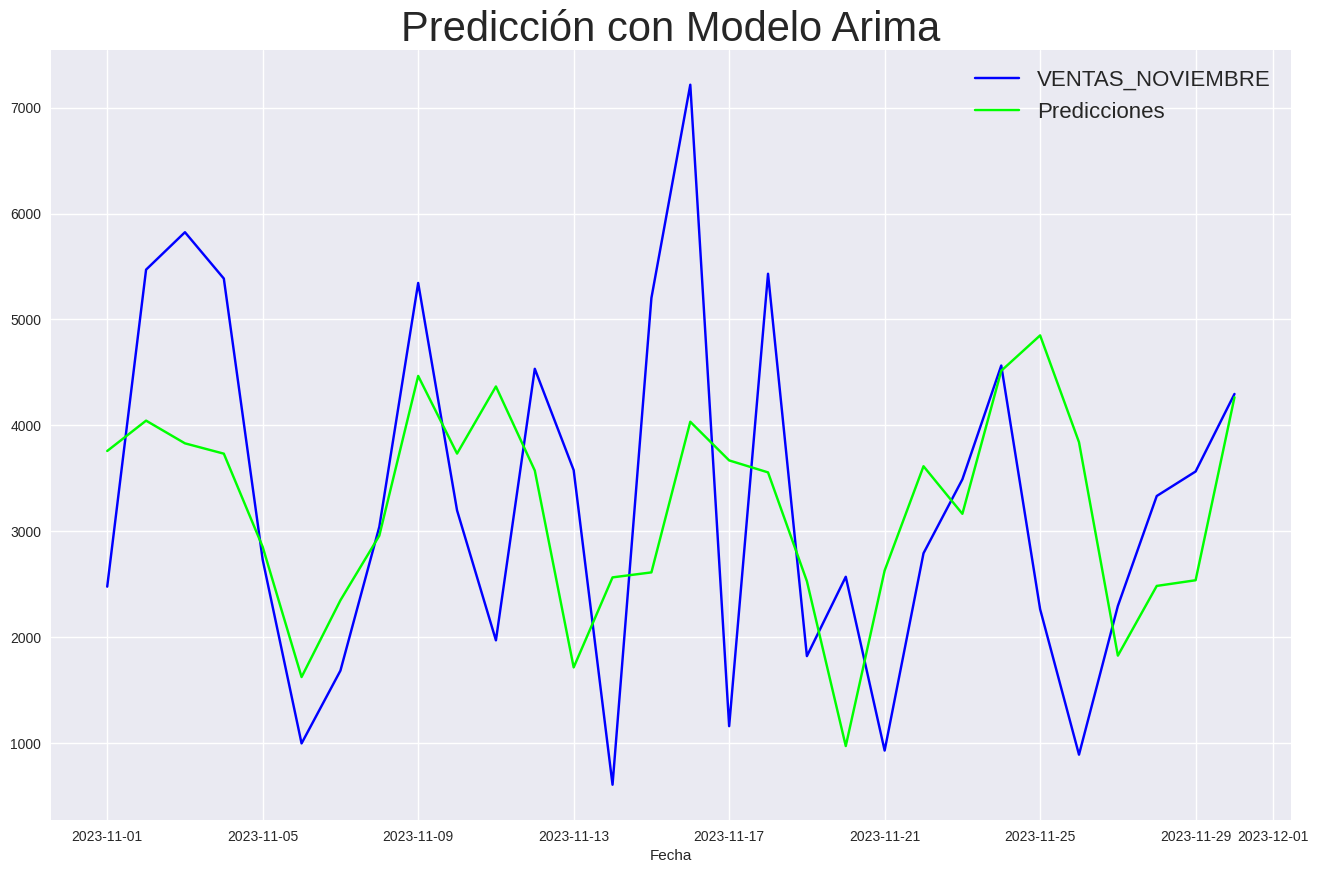

In [100]:
style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)
#plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_desde_2021["FechaMovimiento"], df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima_21['FechaMovimiento'],df_predicciones_arima_21['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30)
xlabel('Fecha')
ylabel('')
legend( fontsize=16)
show()

## Evaluar

In [101]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = df_predicciones_arima_21['Ventas_ARIMA']

# Imprimir el resultado
print(df_noviembre_desde_2021.head(30))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  2476.3271       5559.1777    5880.8711     3757.4609
1       2023-11-02  5469.8955       6317.3147    4871.6128     4044.1015
2       2023-11-03  5823.3412       6905.2325    3354.1594     3829.6748
3       2023-11-04  5385.7282       6411.0504    5254.8330     3732.1404
4       2023-11-05  2729.9860       5225.3764    4249.0576     2851.6236
5       2023-11-06   996.0257       5285.4424    6336.0591     1622.8229
6       2023-11-07  1683.6664       4813.8974    7766.0605     2347.9787
7       2023-11-08  3041.4504       5628.4682    6399.9971     2957.8899
8       2023-11-09  5344.3076       6316.4244    4829.7236     4466.2570
9       2023-11-10  3196.6041       6837.7522    3646.5146     3732.8927
10      2023-11-11  1969.6056       6281.9465    3266.3840     4366.8353
11      2023-11-12  4533.3930       5040.8363    5947.5674     3572.9372
12      2023-11-13  3576.5896       5052.6922    59

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 2568216.8214231716
MAE is : 1323.9059238931463
R2 is : 0.10934377978170295 %
------------------------------
MRSE is : 1602.565699565285
MAPE is : 66.45926480993674 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# TODAS LAS EVALUACIONES

In [106]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:  
MSE is : 8650133.903489279
MAE is : 2593.652294547958
R2 is : -1.9998618117432105 %
------------------------------
MRSE is : 2941.1109981585664
MAPE is : 154.9207686055499 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


---------- LSTM ----------
Evaluation metric results:  
MSE is : 9511777.741189875
MAE is : 2392.352220878907
R2 is : -2.298679433861086 %
------------------------------
MRSE is : 3084.1170115917903
MAPE is : 150.9406736917653 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


---------- ARIMA ----------
Evaluation metric results:  
MSE is : 2389483.8641911466
MAE is : 1286.4472444305222
R2 is : 0.17132827376554782 %
--------

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-107-b20ea7382dad>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


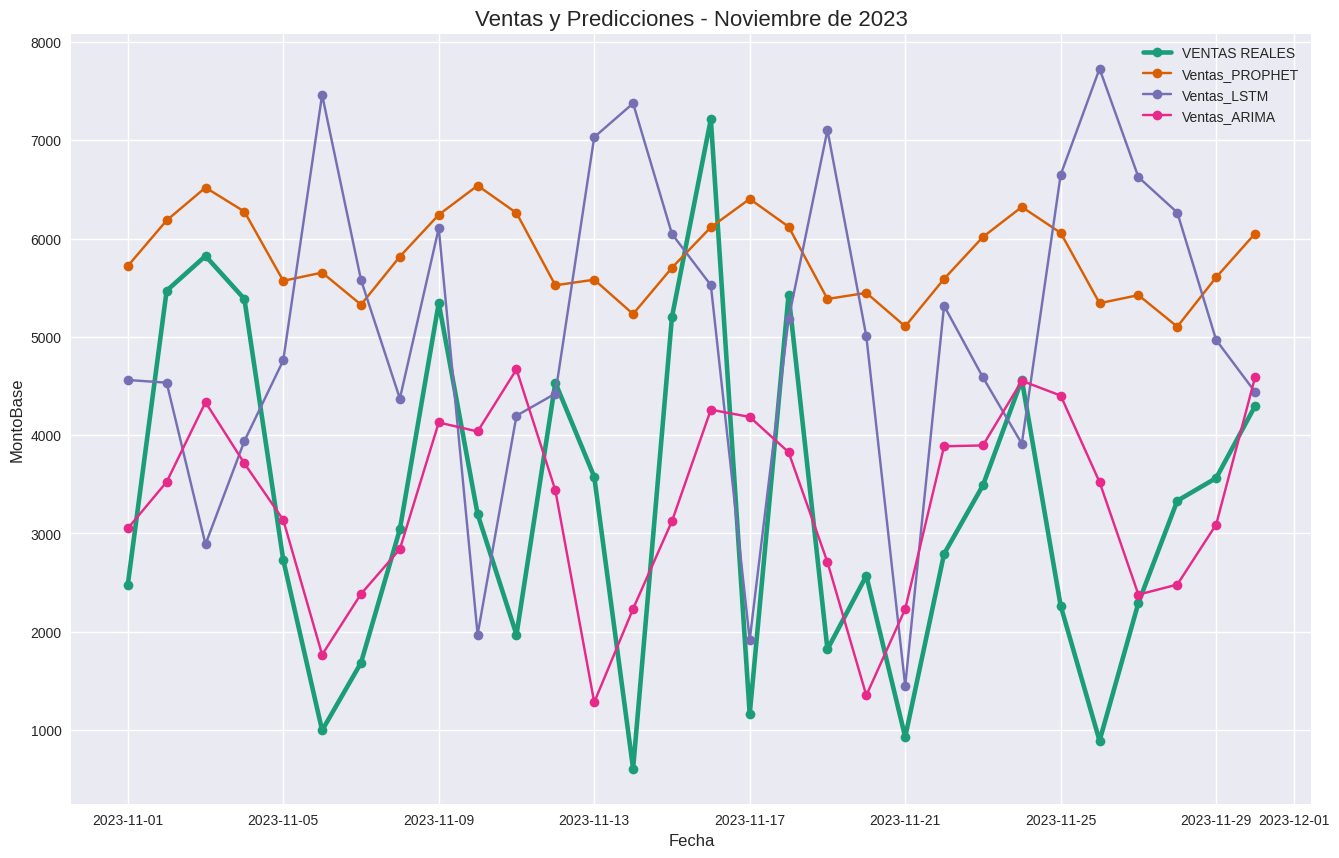

In [107]:
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
figure(figsize=(16, 10))
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-108-ae4643b71aae>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


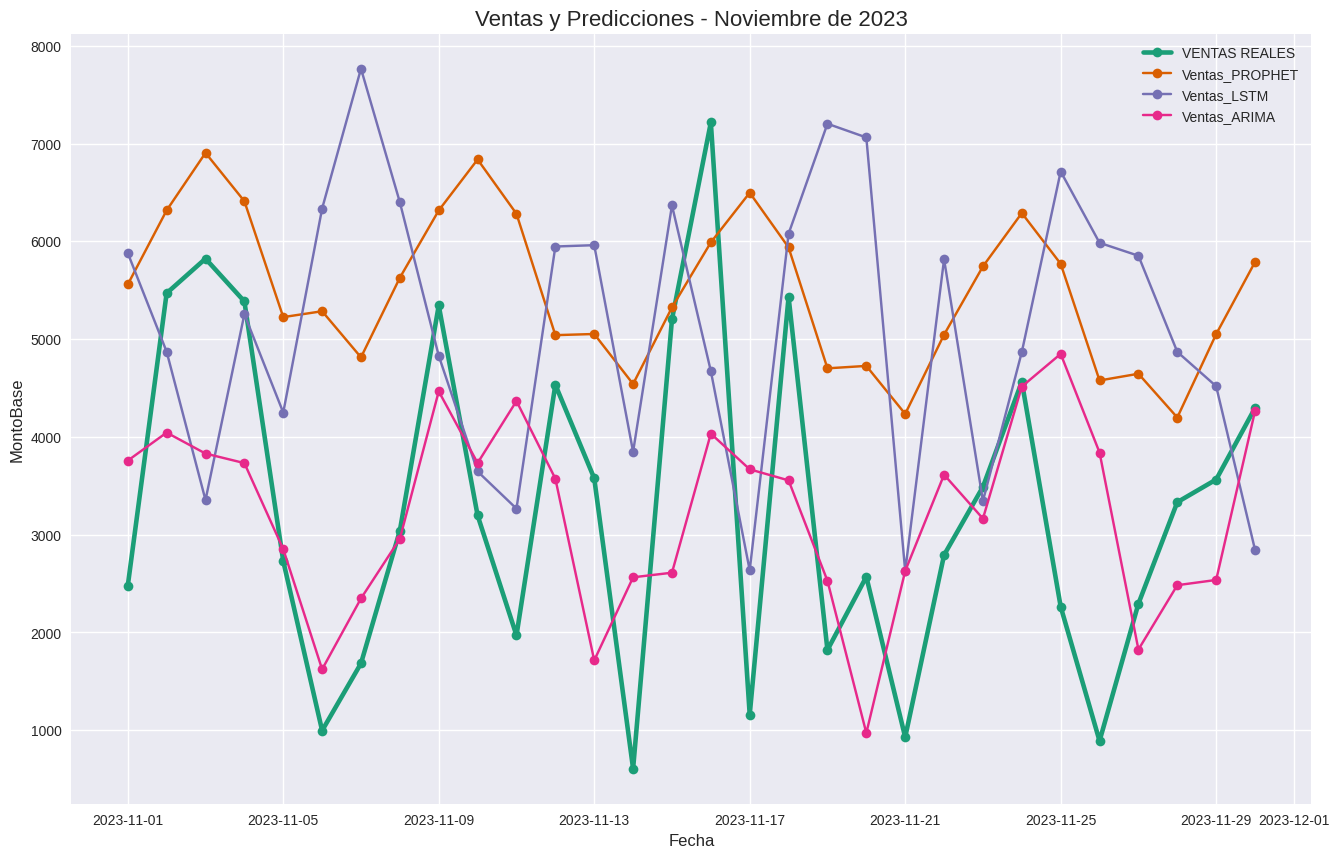

In [108]:
# Establecer el estilo de Seaborn
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
figure(figsize=(16, 10))
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()